In [1]:
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

/opt/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def sigma(x):
    return 1./(1. + np.exp(-x))

In [4]:
class RBM:
    def __init__(self, input_size=784, hidden_size=100):
        xavier_range = np.sqrt(6.0/(input_size + hidden_size))
#         self.W = np.random.uniform(-xavier_range, xavier_range, (input_size, hidden_size))
        self.W = np.random.rand(input_size, hidden_size) * 0.5
        self.b = np.zeros((1,hidden_size))
        self.a = np.zeros((1,input_size))
        self.input_size = input_size
        self.hidden_size = hidden_size
    
    def front_propagation(self, input_visible):
        activated_hidden = sigma(np.matmul(input_visible, self.W) + self.b)
        rand_array = np.random.rand(activated_hidden.shape[0], activated_hidden.shape[1])
        h = (activated_hidden > rand_array).astype('int')
        return h
    
    def back_propagation(self, input_hidden):
        return sigma(np.matmul(input_hidden, np.transpose(self.W)) + self.a)
        
    
    def train(self, X, learning_rate=0.001, generating=False):
        number_of_data = X.shape[0]
        h = self.front_propagation(X)
        
        if generating:
            random_seed = np.random.randn(int(number_of_data/4), self.input_size)
            temp_1 = self.back_propagation(self.front_propagation(random_seed))
            temp_2 = self.back_propagation(self.front_propagation(temp_1))
            temp_3 = self.back_propagation(self.front_propagation(temp_2))
            temp_4 = self.back_propagation(self.front_propagation(temp_3))
            self.X1 = np.concatenate((temp_1, temp_2, temp_3, temp_4), axis=0)
        
        h1 = self.front_propagation(self.X1)
        
    
        dW = np.matmul(np.transpose(X), h) - np.matmul(np.transpose(self.X1), h1)
        db = np.sum(h - h1, axis=0, keepdims=True)
        da = np.sum(X - self.X1, axis=0, keepdims=True)
        
        self.W += learning_rate * dW / number_of_data
        self.b += learning_rate * db / number_of_data
        self.a += learning_rate * da / number_of_data

        error = np.mean(np.sum((X - self.X1) ** 2, axis=1))
        self.X1 = self.back_propagation(h1)
        
        return error
        
    def generate_images(self, number_of_images=20, n_step=200):
        hidden = np.round(np.random.rand(number_of_images, self.hidden_size))
        for i in range(n_step):
            visible = self.back_propagation(hidden)
            hidden = self.front_propagation(visible)
        return visible
    
    def generate_hidden(self, X, n_step=200):
        visible = X
        for i in range(n_step):
            hidden = self.front_propagation(visible)
            visible = self.back_propagation(hidden)
        return hidden

In [5]:
models = [RBM(hidden_size=100), RBM(input_size=100, hidden_size=40)]

In [6]:
BATCH_SIZE = 100
TRAINING_EPOCHS = 50

In [7]:
total_batch = int(mnist.train.num_examples / BATCH_SIZE)

In [8]:
for model_num, model in enumerate(models):
    for epoch in range(TRAINING_EPOCHS):
        total_error = 0
        check = True
        for i in range(total_batch):
            input_data = mnist.train.next_batch(BATCH_SIZE)[0]
            if model_num == 1:
                input_data = models[0].generate_hidden(input_data, n_step=1)
            total_error += model.train(input_data, generating=check)/total_batch
            if check:
                check = False
        print('Epoch: ' + str((epoch + 1)) + ': ' + str(total_error) )

    print('Learning Finished!')


Epoch: 1: 369.699900328
Epoch: 2: 106.34009779
Epoch: 3: 101.397552583
Epoch: 4: 92.938148706
Epoch: 5: 80.8251451525
Epoch: 6: 78.2146461738
Epoch: 7: 72.716685896
Epoch: 8: 70.7633013705
Epoch: 9: 69.6206459596
Epoch: 10: 69.6034459229
Epoch: 11: 69.2138151968
Epoch: 12: 69.1112018431
Epoch: 13: 70.0607372157
Epoch: 14: 70.8838568608
Epoch: 15: 70.248681604
Epoch: 16: 71.5464674049
Epoch: 17: 71.1514320892
Epoch: 18: 71.4202430555
Epoch: 19: 72.7055412166
Epoch: 20: 72.2616347572
Epoch: 21: 73.2156578143
Epoch: 22: 72.9644245027
Epoch: 23: 72.9993056541
Epoch: 24: 73.2910795521
Epoch: 25: 73.589255319
Epoch: 26: 73.7652450174
Epoch: 27: 73.9044289658
Epoch: 28: 74.1683338218
Epoch: 29: 74.4664837266
Epoch: 30: 75.1956326218
Epoch: 31: 74.9083415206
Epoch: 32: 75.1336690219
Epoch: 33: 75.4019363427
Epoch: 34: 75.7124642118
Epoch: 35: 75.7196157343
Epoch: 36: 75.7864524188
Epoch: 37: 76.1982003617
Epoch: 38: 76.2731234856
Epoch: 39: 76.5776298009
Epoch: 40: 76.6996615017
Epoch: 41: 76.

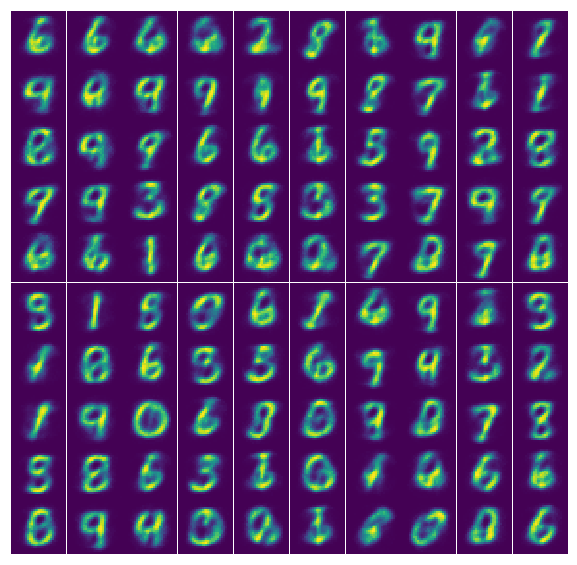

In [9]:
input_data = models[1].generate_images(number_of_images=100)
images = sigma(np.matmul(input_data, np.transpose(models[0].W)) + models[0].a)
reshaped_images = np.reshape(images, (-1, 28, 28))
f, axarr = plt.subplots(10, 10, figsize=(10,10))
for i in range(10):
    for j in range(10):
        axarr[i, j].imshow(reshaped_images[i*10 + j])
        axarr[i, j].axis('off')
        axarr[i, j].set_xticklabels([])
        axarr[i, j].set_yticklabels([])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [10]:
hidden_input = models[0].generate_hidden(mnist.train.images, n_step=1)
hidden_array = models[1].generate_hidden(hidden_input, n_step=1)

In [11]:
hidden_string_array = []
for data in hidden_array:
    string = ''
    for row in data:
        string += str(row)
    hidden_string_array.append(string)
from collections import Counter
counter = Counter(hidden_string_array)
p_x = np.array(list(counter.values()))/len(hidden_array)
entropy_h = np.sum(-p_x * np.log(p_x))

counter_2 = Counter(counter.values())
p_x2 = np.array([k*v/len(hidden_array) for k, v in counter_2.items()])
entropy_k = np.sum(-p_x2 * np.log(p_x2))
entropy_h, entropy_k

(10.703116110806402, 0.69916890406333676)